In [57]:
import numpy as np
import netCDF4 as nc4
import matplotlib as mpl
import matplotlib.pylab as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pandas as pd
import matplotlib.colors as colors

In [3]:
df = pd.read_csv(r'/../doppler/data8/pilewskie/convective_object_database/postprocessed_data/CONUS_COs_06to16_032924.csv', \
    low_memory=False)


In [6]:
for col in df.columns:
    print(col)

Mean longitude
Mean latitude
Julian day
Day or Night
Granule
Freeze level
Year
Surface flag
CO index
Initial CO pixel
Final CO pixel
CO size
Z Volume
CTH
Mean TB11
TB11 lt 195 frac
TB11 lt 220 frac
TB11 lt 235 frac
Cloud flags
Conv frac
Conv frac whole
Strat frac
Shall conv frac
COD lt 1 frac
COD 1 to 3 frac
COD gt 3 frac
Missing COD frac
Max Z value
Max Z height
Max Z gt 10 frac
Max Z gt 0 frac
Shallow cloud frac
Upper cloud frac
Initial core index
Final core index
Core CoG
Core Rel CoG
Max Z Core CoG
Max Z Core Rel CoG
Core RTH
No of cores
Core sizes
Core max height Z gt 10
Core max height Z gt 0
Core Latitudes
Core Longitudes
Core TB11
Core LRT Height
Core CPT Height
Hot Tower Flags
Core Max CTH
Precip flags
Mean Rain Rate
Cond Rain Rate
Mean CWV
Mean CLWP
IWP volume
SWP volume
Anvil mean COD
Anvil COD volume
Anvil mean IWP
Anvil IWP volume
Mean IWP
Mean Rain IWP
Rain length
Mean Non-rain IWP
Non-rain length
Mean LW CRE
Mean SW CRE
Mean Net CRE
Warming frac
Cooling frac
Mean CO Gree

In [5]:
# Reading in variables
year = df['Year']; j_day = df['Julian day']; co_lats = df['Mean latitude']; co_lons = df['Mean longitude']
co_size = np.array(df["CO size"]); core_rcog = np.array(df["Core Rel CoG"])
cond_rain_rate = np.array(df["Cond Rain Rate"])

In [26]:
# Converting strings to floats

# Core rCoG
core_rcog_fl = [] 
for i in range(len(core_rcog)):
    core_rcog_fl.append(np.mean([float(f) for f in core_rcog[i].strip("[]").split(',')]))

In [105]:
# Indices for seasons over CONUS

idx_conus = [i for i, x in enumerate(co_lons) if -140 <= x <= -60 and 25 <= co_lats[i] <= 50]

idx_djf = [i for i, x in enumerate(j_day) if -140 <= co_lons[i] <= -60 and 25 <= co_lats[i] <= 50 and \
    ((1 <= x <= 59 or 335 <= x <= 365 and (year[i] != 2008 or year[i] != \
    2012 or year[i] != 2016)) or (1 <= x <= 60 or 336 <= x <= 366 and (year[i] == 2008 or year[i] == \
    2012 or year[i] == 2016)))] 

idx_mam = [i for i, x in enumerate(j_day) if -140 <= co_lons[i] <= -60 and 25 <= co_lats[i] <= 50 and \
    ((60 <= x <= 151 and (year[i] != 2008 or year[i] != 2012 or year[i] != 2016)) or (61 <= x <= 152 and \
    (year[i] == 2008 or year[i] == 2012 or year[i] == 2016)))]  

idx_jja = [i for i, x in enumerate(j_day) if -140 <= co_lons[i] <= -60 and 25 <= co_lats[i] <= 50 and \
    ((152 <= x <= 243 and (year[i] != 2008 or year[i] != 2012 or year[i] != 2016)) or (153 <= x <= 244 and \
    (year[i] == 2008 or year[i] == 2012 or year[i] == 2016)))]

idx_son = [i for i, x in enumerate(j_day) if -140 <= co_lons[i] <= -60 and 25 <= co_lats[i] <= 50 and \
    ((244 <= x <= 334 and (year[i] != 2008 or year[i] != 2012 or year[i] != 2016)) or (245 <= x <= 335 and \
    (year[i] == 2008 or year[i] == 2012 or year[i] == 2016)))]

idx_ssns = [idx_djf, idx_mam, idx_jja, idx_son]

In [9]:
def extreme_conv(variable):

    # Finding the cutoff value for the most extreme convective objects
    top10p = np.percentile(variable, 90) # lowest value for top 10% of most extreme storms
    top5p = np.percentile(variable, 95) # lowest value for top 5% of most extreme storms
    top1p = np.percentile(variable, 99) # lowest value for top 1% of most extreme storms
    toppt1p = np.percentile(variable, 99.9) # lowest value for top 0.1% of most extreme storms

    top_vals = [top10p, top5p, top1p, toppt1p]

    # Indices of most intense objects to use for partitioning other data
    idx_top10p = [i for i,x in enumerate(variable) if x >= top10p]
    idx_top5p = [i for i,x in enumerate(variable) if x >= top5p]
    idx_top1p = [i for i,x in enumerate(variable) if x >= top1p]
    idx_toppt1p = [i for i,x in enumerate(variable) if x >= toppt1p]

    idx_topp = [idx_top10p, idx_top5p, idx_top1p, idx_toppt1p]

    return(top_vals, idx_topp)

In [164]:
def population_map(lons, lats, var, vmin, vmax, cbar_label, title): 
    
    '''Function for plotting CO variables in the tropics'''

    # Coordinates of interest
    llon = -140; ulon = -60
    llat = 25; ulat = 50

    # Setting up map
    fig = plt.figure(figsize = (15,7))
    ax=plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([llon, ulon, llat, ulat], ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree())
    ax.set_extent([llon, ulon, llat, ulat], ccrs.PlateCarree())
    ax.set_xticks(np.linspace(llon,ulon,5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(llat,ulat,10), crs=ccrs.PlateCarree())
    ax.tick_params(axis='both', labelsize=25)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.coastlines()
    
    # Define the colormap
    cmap = plt.cm.jet  
    cmaplist = [cmap(i) for i in range(cmap.N)] # extract all colors from the .jet map
    cmaplist[0] = (.5, .5, .5, 1.0) # force the first color entry to be grey

    # Create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

    # Define the bins and normalize
    bounds = np.linspace(vmin, vmax, 11)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    # Plotting on map
        
    # Plotting location of COs
    #plt.plot(lons, lats, 'b.', markersize=5, transform=ccrs.PlateCarree())
    cs = plt.scatter(lons, lats, c=var, s=10, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    
    # Title
    ax.set_title(title, fontsize = 40)
    
    # Colorbar
    cb_ax = fig.add_axes([0.92, 0.25, 0.03, 0.5])
    cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, \
                                   boundaries=bounds, format='%.1f')
    cb.ax.tick_params(labelsize=20, direction="in")        
    cb.set_label(cbar_label, fontsize=30)

    plt.show()

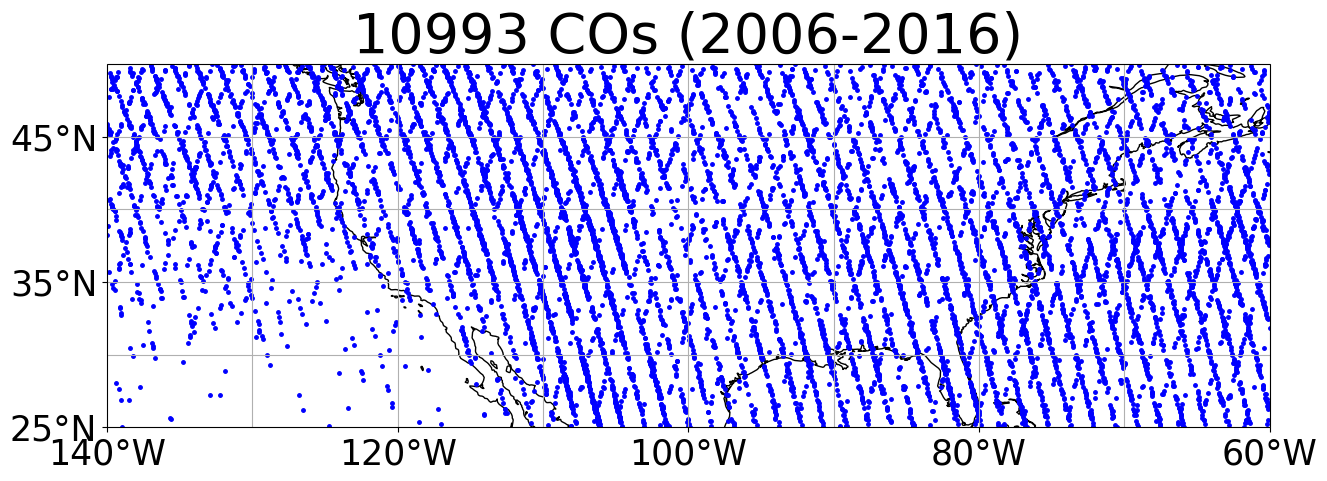

In [163]:
population_map(co_lons[idx_conus], co_lats[idx_conus], np.array(core_rcog_fl)[idx_conus], 1, 6, \
            'Relative CoG (km)', '%.0f ' % len(co_lons[idx_conus]) + 'COs (2006-2016)')

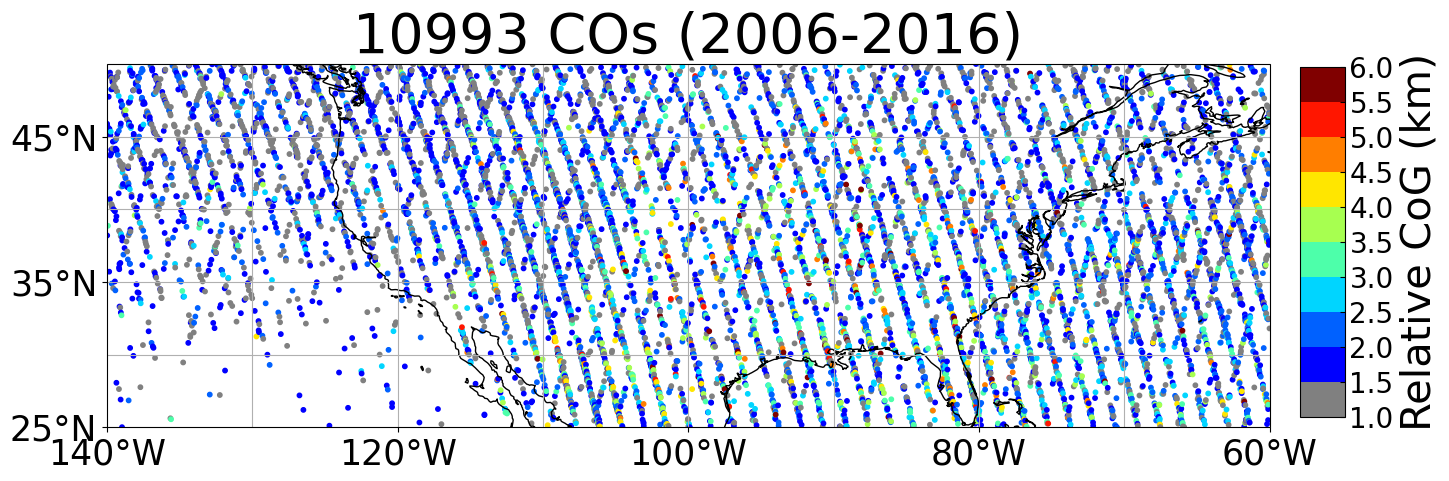

In [165]:
population_map(co_lons[idx_conus], co_lats[idx_conus], np.array(core_rcog_fl)[idx_conus], 1, 6, \
            'Relative CoG (km)', '%.0f ' % len(co_lons[idx_conus]) + 'COs (2006-2016)')

In [154]:
def population_map_ssns(lons, lats, var, idxs, vmin, vmax, cbar_label, ssn): 
    
    '''Function for plotting CO variables in the tropics'''

    # Coordinates of interest
    llon = -140; ulon = -60
    llat = 25; ulat = 50

    # Setting up map
    fig, axs = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15, 6))
    
    for i, ax in enumerate(axs.flat):
        ax.set_extent([llon, ulon, llat, ulat], ccrs.PlateCarree())
        ax.gridlines(crs=ccrs.PlateCarree())
        ax.set_extent([llon, ulon, llat, ulat], ccrs.PlateCarree())
        ax.set_xticks(np.linspace(llon,ulon,5), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(llat,ulat,10), crs=ccrs.PlateCarree())
        ax.tick_params(axis='both', labelsize=15)
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.coastlines()
        
        # Define the colormap
        cmap = plt.cm.jet  
        cmaplist = [cmap(i) for i in range(cmap.N)] # extract all colors from the .jet map
        cmaplist[0] = (.5, .5, .5, 1.0) # force the first color entry to be grey

        # Create the new map
        cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

        # Define the bins and normalize
        bounds = np.linspace(vmin, vmax, 11)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
        # Plotting on map
        
        # Plotting location of COs
        #plt.plot(lons, lats, 'k.', markersize=2, transform=ccrs.PlateCarree())
        cs = ax.scatter(lons[idxs[i]], lats[idxs[i]], c=var[idxs[i]], s=10, cmap=cmap, norm=norm, \
                         transform=ccrs.PlateCarree())
            
        # Plotting extremes sorted by percentages
        #plt.plot(x[i], y[i], markers[i], markersize=10, color=color[i], markeredgecolor=color[i], \
        #label='Top ' + label[i]) # + ' (' + varname + ' >' + ' %.0f ' % z[i] + units + ', ' + \
        #str(len(x[i])) + ' COs)') # Top 10%, 5%, 1%, and 0.1%
        
        # Plotting seasonality of top 5% most intense populations
#         plt.plot(x[i][z[i]], y[i][z[i]], markers[i], markersize=10, markerfacecolor="None", \
#         markeredgecolor=color[i], markeredgewidth=2, label=label[i])# + ' (' + str(len(x[i][z[i]])) + ' COs)') # Sorting by seasons
        
        #plt.legend(loc='lower right', ncol=4, fontsize=35) # labelspacing=0.05,
        #plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.27), ncol=4, fontsize=35)  
    
        # Title
        ax.set_title(ssn[i] + ' (%.0f ' % len(lons[idxs[i]]) + 'COs)', fontsize = 20)
    
    # Colorbar
    cb_ax = fig.add_axes([0.93, 0.1, 0.03, 0.8])
    cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, \
                                   boundaries=bounds, format='%.1f')
    cb.ax.tick_params(labelsize=20, direction="in")        
    cb.set_label(cbar_label, fontsize=30)
    
    fig.suptitle('ALL COs (2006-2016)', fontsize=40)

    plt.show()

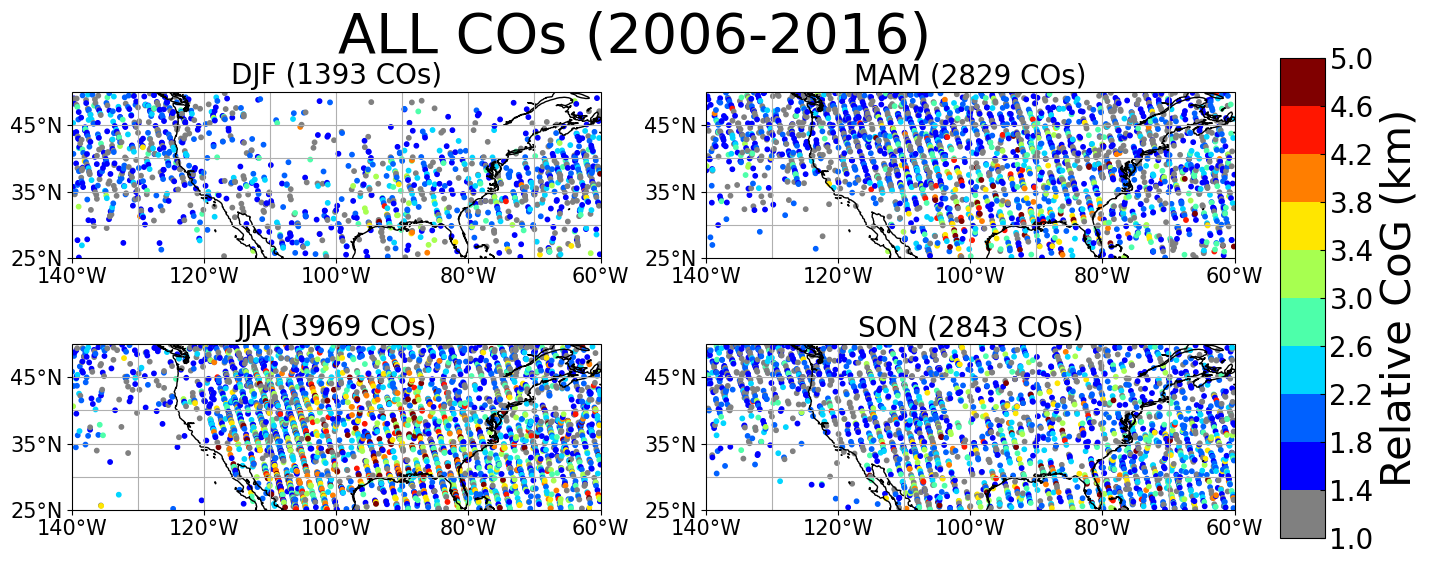

In [155]:
population_map_ssns(co_lons, co_lats, np.array(core_rcog_fl), idx_ssns, 1, 5, 'Relative CoG (km)', \
                    ['DJF', 'MAM', 'JJA', 'SON'])

In [104]:
len(co_lons[idx_djf])

1393